# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on XPS spectra made up of linear combinations of reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [2]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Set random seed for reproducible loading
np.random.seed(502)

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Install and import TensorFlow

In [3]:
# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf

### Set seeds and restart session to ensure reproducibility

In [4]:
def reset_seeds_and_session(seed=1):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)

   session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                           inter_op_parallelism_threads=1)
   sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                               config=session_conf)
   tf.compat.v1.keras.backend.set_session(sess) 

reset_seeds_and_session(seed=1)

### Check TensorFlow version

In [5]:
f"TF version: {tf.__version__}."

'TF version: 2.8.2.'

### Check hardware connection

In [6]:
from tensorflow.python.profiler import profiler_client

if tf.test.gpu_device_name():
    print(f"Found GPU: {tf.test.gpu_device_name()}.")
    !nvidia-smi
else:
    print("Found no GPU.")
try:
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print(f"Found TPU: {profiler_client.monitor(tpu_profile_service_address, 100, 2)}.")
except:
    print("Found no TPU.")

Found GPU: /device:GPU:0.
Wed Jul  6 04:58:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |    264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

## Initial training

### Load custom modules

In [ ]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [ ]:
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = "Co_linear_combination_normalized_inputs_big_gas_phase"

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = "regression",
                            intensity_only = True)

### If labels not saved with data ###
# =============================================================================
# labels = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
# clf = classifier.Classifier(time = time,
#                            exp_name = exp_name,
#                            task = 'regression',
#                            intensity_only = True,
#                            labels = labels)
# =============================================================================

Model folder created at /20220705_14h53m_Co_linear_combination_normalized_inputs_big_gas_phase/model
Logs folder created at /20220705_14h53m_Co_linear_combination_normalized_inputs_big_gas_phase/logs
Figures folder created at /20220705_14h53m_Co_linear_combination_normalized_inputs_big_gas_phase/figures


### Load and inspect the data

Data was loaded!
Total no. of samples: 200000
No. of training samples: 128000
No. of validation samples: 32000
No. of test samples: 40000
Shape of each sample : 701 features (X) + 3 labels (y)


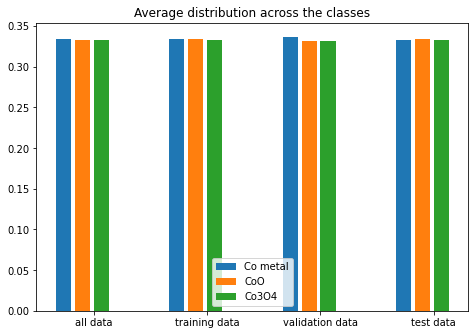

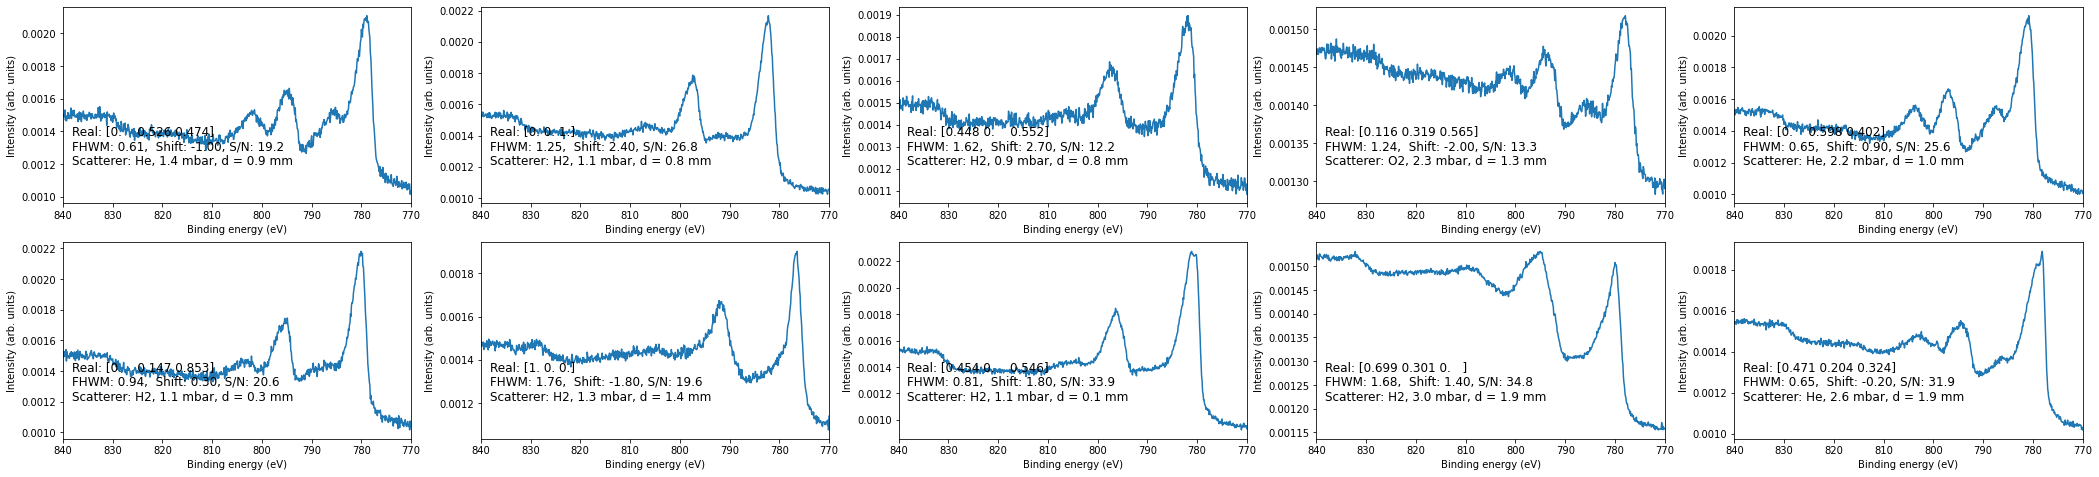

In [ ]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20220704_Co_linear_combination_big_gas_phase.h5'

train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 200000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [ ]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class CNN(models.EmptyModel):
    """
    A CNN with three convolutional layers of different kernel size at 
    the beginning. Works well for learning across scales.
    
    """
    def __init__(
        self, 
        inputshape,
        num_classes,
        task,
        ):   
        if len(inputshape) == 2:
            conv_layer = layers.Conv1D
            strides = 1
            average_pool_layer = layers.AveragePooling1D
        elif len(inputshape) == 3:
            conv_layer = layers.Conv2D
            strides = (1,1)
            average_pool_layer =  layers.AveragePooling2D

        if (task == "regression" or task == "multi_class_detection"):
            if num_classes == 1:
                output_act = None
            else:
                output_act = "sigmoid"
    
        elif task == "classification":
            output_act = "softmax"
        
        self.input_1 = layers.Input(
            shape = inputshape,
            name="input_1")
        self.conv_1_short = conv_layer(
            filters=12,
            kernel_size=5,
            strides=strides,
            padding='same',
            activation='relu',
            name='conv_1_short')(self.input_1)
        self.conv_1_medium = conv_layer(
            filters=12,
            kernel_size=10,
            strides=strides,
            padding='same',
            activation='relu',
            name='conv_1_medium')(self.input_1)
        self.conv_1_long = conv_layer(
            filters=12,
            kernel_size=15,
            strides=strides,
            padding='same',
            activation='relu',
            name='conv_1_long')(self.input_1)
        
        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        merged_sublayers = layers.concatenate(sublayers)

        self.conv_2 = conv_layer(
            filters=10,
            kernel_size=5,
            strides=strides,
            padding='valid',
            activation='relu',
            name='conv_2')(merged_sublayers)
        self.conv_3 = conv_layer(
            filters=10,
            kernel_size=5,
            strides=strides,
            padding='valid',
            activation='relu',
            name="conv_3")(self.conv_2)
        self.average_pool_1 = average_pool_layer(
            name='average_pool_1')(self.conv_3)
        self.flatten_1 = layers.Flatten(
            name='flatten1')(self.average_pool_1)
        self.drop_1 = layers.Dropout(
            rate=0.2,
            name='drop_1')(self.flatten_1)
        self.dense_1 = layers.Dense(
            units=4000,
            activation='relu',
            name='dense_1')(self.flatten_1)    
        self.dense_2 = layers.Dense(
            units=num_classes,
            activation=output_act,
            name='dense_2')(self.dense_1)
              
        if task == "regression":
            self.outputs = layers.Lambda(
                lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
                name = 'output_normalization')(self.dense_2)
        
        else:
            self.outputs = self.dense_2

        no_of_inputs = len(sublayers)

        super(CNN, self).__init__(
            inputs=self.input_1,
            outputs=self.outputs,
            inputshape=inputshape,
            num_classes=num_classes,
            no_of_inputs=no_of_inputs,
            name='CNN')

#### Build the model

In [ ]:
clf.model = CNN(clf.datahandler.input_shape,
                clf.datahandler.num_classes,
                task=clf.task)

# =============================================================================
# clf.model = ResNet1D(clf.datahandler.input_shape,
#                      clf.datahandler.num_classess,
#                      ap=True)
# =============================================================================

# Alternative: Build model from available models in models.py
# =============================================================================
# clf.model = models.RegressionCNN(clf.datahandler.input_shape, 
#                                  clf.datahandler.num_classes)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================

### Compile and summarize the model

Model: "CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 701, 1)]     0           []                               
                                                                                                  
 conv_1_short (Conv1D)          (None, 701, 12)      72          ['input_1[0][0]']                
                                                                                                  
 conv_1_medium (Conv1D)         (None, 701, 12)      132         ['input_1[0][0]']                
                                                                                                  
 conv_1_long (Conv1D)           (None, 701, 12)      192         ['input_1[0][0]']                
                                                                                                

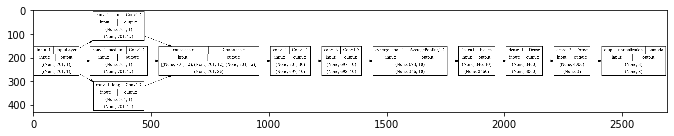

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import MeanSquaredError, CategoricalCrossentropy, BinaryAccuracy
    

learning_rate = 1e-05 #3e-04
optimizer = Adam(learning_rate = learning_rate) 

if clf.task == "regression":
    loss = MeanAbsoluteError()
    #loss = MeanSquaredError()
    metrics=[MeanSquaredError(name="mse")]
    
elif clf.task == "classification":
    loss = CategoricalCrossentropy()
    metrics = [CategoricalCrossentropy(name="accuracy")]
    
elif clf.task == "multi_class_detection":
    loss = BinaryCrossentropy()
    metrics = metrics = [BinaryAccuracy(name="accuracy")]
    
clf.model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_train[i],3)),
          'pred: ' + str(pred_train_initial[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_test[i],3)),
          'pred: ' + str(pred_test_initial[i]))

1250/1250 [==============================] - 3s 2ms/step
Prediction done!
Train:
real: [0. 0. 1.] pred: [0.33331415 0.33336362 0.33332217]
real: [0.38  0.315 0.305] pred: [0.3333141  0.33336362 0.33332232]
real: [0.133 0.412 0.455] pred: [0.3333145  0.33336264 0.33332288]
real: [0.    0.349 0.651] pred: [0.3333136  0.33335727 0.3333291 ]
real: [0.386 0.614 0.   ] pred: [0.33331352 0.33335963 0.33332685]
Test:
real: [0.415 0.315 0.269] pred: [0.3333164  0.33336386 0.33331978]
real: [0.227 0.773 0.   ] pred: [0.33331442 0.33336136 0.33332425]
real: [0. 1. 0.] pred: [0.33331355 0.33336112 0.33332527]
real: [0. 1. 0.] pred: [0.3333142  0.3333621  0.33332363]
real: [0.304 0.116 0.58 ] pred: [0.3333141  0.33336437 0.33332154]


### Train

In [ ]:
epochs = 500
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

Epoch 1/500
4000/4000 [==============================] - 37s 9ms/step - loss: 0.2697 - mse: 0.1071 - val_loss: 0.2671 - val_mse: 0.1051
Epoch 2/500
4000/4000 [==============================] - 35s 9ms/step - loss: 0.2609 - mse: 0.1005 - val_loss: 0.2562 - val_mse: 0.0972
Epoch 3/500
4000/4000 [==============================] - 34s 9ms/step - loss: 0.2515 - mse: 0.0943 - val_loss: 0.2427 - val_mse: 0.0887
Epoch 4/500
4000/4000 [==============================] - 34s 9ms/step - loss: 0.2330 - mse: 0.0837 - val_loss: 0.2249 - val_mse: 0.0797
Epoch 5/500
4000/4000 [==============================] - 34s 9ms/step - loss: 0.2164 - mse: 0.0754 - val_loss: 0.2086 - val_mse: 0.0712
Epoch 6/500
4000/4000 [==============================] - 34s 9ms/step - loss: 0.2028 - mse: 0.0682 - val_loss: 0.1962 - val_mse: 0.0645
Epoch 7/500
4000/4000 [==============================] - 34s 9ms/step - loss: 0.1922 - mse: 0.0624 - val_loss: 0.1874 - val_mse: 0.0599
Epoch 8/500
4000/4000 [=========================

### Plot loss

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task != "regression":
    graph.plot_accuracy(to_file = False)

### Evaluate on test data

In [ ]:
if clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

else:
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task != "regression":
    pred_train_classes, pred_test_classes = clf.predict_classes()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_train[i],3)),
          'pred: ' + str(pred_train[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_test[i],3)),
          'pred: ' + str(pred_test[i]))

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
else:
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and results

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

## Continue training

### Load custom modules

In [7]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')


 Modules were loaded.


### Reload classifier from previous run

In [8]:
runpath = r"/content/drive/My Drive/deepxps/runs/20220705_14h53m_Co_linear_combination_normalized_inputs_big_gas_phase"
clf = classifier.restore_clf_from_logs(runpath)

Model folder was already at /20220705_14h53m_Co_linear_combination_normalized_inputs_big_gas_phase/model
Logs folder was already at /20220705_14h53m_Co_linear_combination_normalized_inputs_big_gas_phase/logs
Figures folder was already at /20220705_14h53m_Co_linear_combination_normalized_inputs_big_gas_phase/figures
Recovered classifier from file.


### Load and inspect the data

Data was loaded!
Total no. of samples: 200000
No. of training samples: 128000
No. of validation samples: 32000
No. of test samples: 40000
Shape of each sample : 701 features (X) + 3 labels (y)


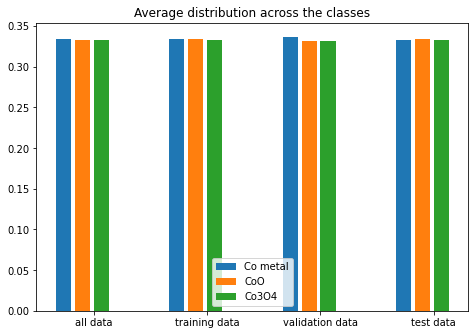

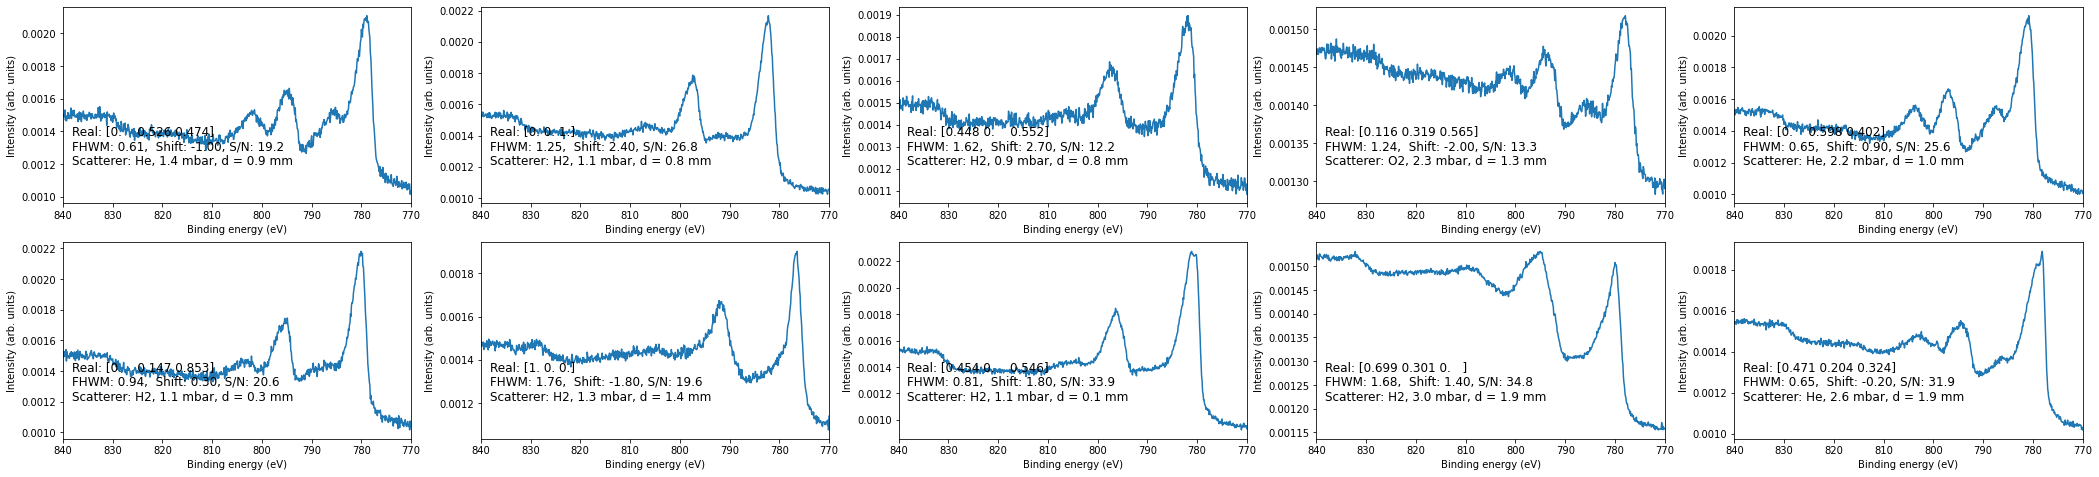

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(
            input_filepath = clf.logging.hyperparams['input_filepath'],
            no_of_examples = clf.logging.hyperparams['no_of_examples'],
            train_test_split = clf.logging.hyperparams['train_test_split'],
            train_val_split = clf.logging.hyperparams['train_val_split'])
                
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [10]:
from tensorflow.keras import backend as K
clf.load_model(compile_model = True)

Loaded model from disk.


### Summarize the model

Model: "Loaded_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 701, 1)]     0           []                               
                                                                                                  
 conv_1_short (Conv1D)          (None, 701, 12)      72          ['input_1[0][0]']                
                                                                                                  
 conv_1_medium (Conv1D)         (None, 701, 12)      132         ['input_1[0][0]']                
                                                                                                  
 conv_1_long (Conv1D)           (None, 701, 12)      192         ['input_1[0][0]']                
                                                                                       

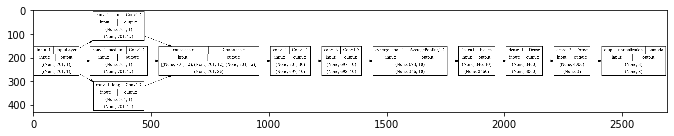

In [11]:
# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show predictions with current model

1250/1250 [==============================] - 3s 2ms/step
Prediction done!
Train:
real: [0. 0. 1.] pred: [0.03605163 0.00298283 0.9609656 ]
real: [0.38  0.315 0.305] pred: [0.40661168 0.3346303  0.258758  ]
real: [0.133 0.412 0.455] pred: [0.05966245 0.42394263 0.516395  ]
real: [0.    0.349 0.651] pred: [3.7891117e-09 3.5733062e-01 6.4266932e-01]
real: [0.386 0.614 0.   ] pred: [0.39791825 0.60050875 0.00157301]
Test:
real: [0.415 0.315 0.269] pred: [0.4125498  0.3136345  0.27381566]
real: [0.227 0.773 0.   ] pred: [0.22892916 0.76259136 0.00847949]
real: [0. 1. 0.] pred: [1.2386684e-09 9.9999952e-01 4.9589784e-07]
real: [0. 1. 0.] pred: [1.4579941e-06 9.9975842e-01 2.4011859e-04]
real: [0.304 0.116 0.58 ] pred: [0.30696547 0.11126012 0.58177435]
Calculating loss for each example...
Done!


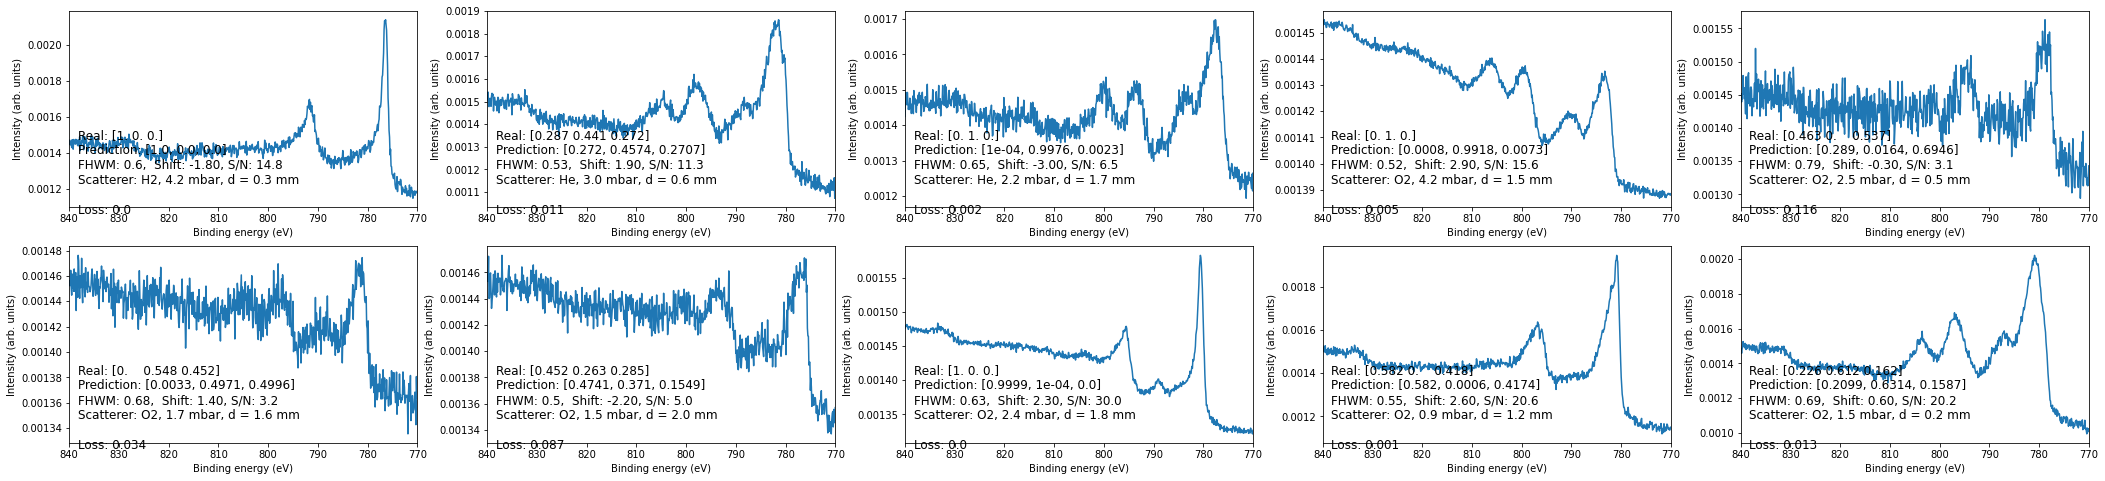

In [12]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))
    
clf.plot_random(no_of_spectra=10, dataset='test', with_prediction=True)

In [13]:
500 - clf.logging.hyperparams["epochs_trained"]

126

### Train

In [14]:
epochs = 126

#new_learning_rate = 5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

Epoch 375/500
4000/4000 [==============================] - 41s 10ms/step - loss: 0.0211 - mse: 0.0020 - val_loss: 0.0211 - val_mse: 0.0020
Epoch 376/500
4000/4000 [==============================] - 32s 8ms/step - loss: 0.0210 - mse: 0.0020 - val_loss: 0.0246 - val_mse: 0.0026
Epoch 377/500
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0212 - mse: 0.0021 - val_loss: 0.0227 - val_mse: 0.0023
Epoch 378/500
4000/4000 [==============================] - 30s 8ms/step - loss: 0.0210 - mse: 0.0020 - val_loss: 0.0216 - val_mse: 0.0024
Epoch 379/500
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0210 - mse: 0.0020 - val_loss: 0.0219 - val_mse: 0.0020
Epoch 380/500
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0209 - mse: 0.0021 - val_loss: 0.0253 - val_mse: 0.0025
Epoch 381/500
4000/4000 [==============================] - 31s 8ms/step - loss: 0.0209 - mse: 0.0020 - val_loss: 0.0231 - val_mse: 0.0021
Epoch 382/500
4000/4000 [========

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))
    
clf.plot_random(no_of_spectra=10, dataset='test', with_prediction=True)

### Train

In [ ]:
epochs = 1000

#new_learning_rate = 5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Plot loss

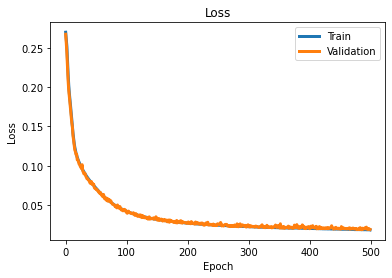

In [15]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task != "regression":
    graph.plot_accuracy(to_file = True)

### Evaluate on test data

In [16]:
if clf.task == "regression":
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    
else:
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

1250/1250 [==============================] - 3s 3ms/step - loss: 0.0195 - mse: 0.0018
Evaluation done! 

Test loss: [0.01950019 0.00178999]


###  Predict on train and test data

In [17]:
pred_train, pred_test = clf.predict()
if clf.task == "classification":
    pred_train_classes, pred_test_classes = clf.predict_classes()

1250/1250 [==============================] - 3s 2ms/step
Prediction done!


### Show some predictions

#### 10 random training samples

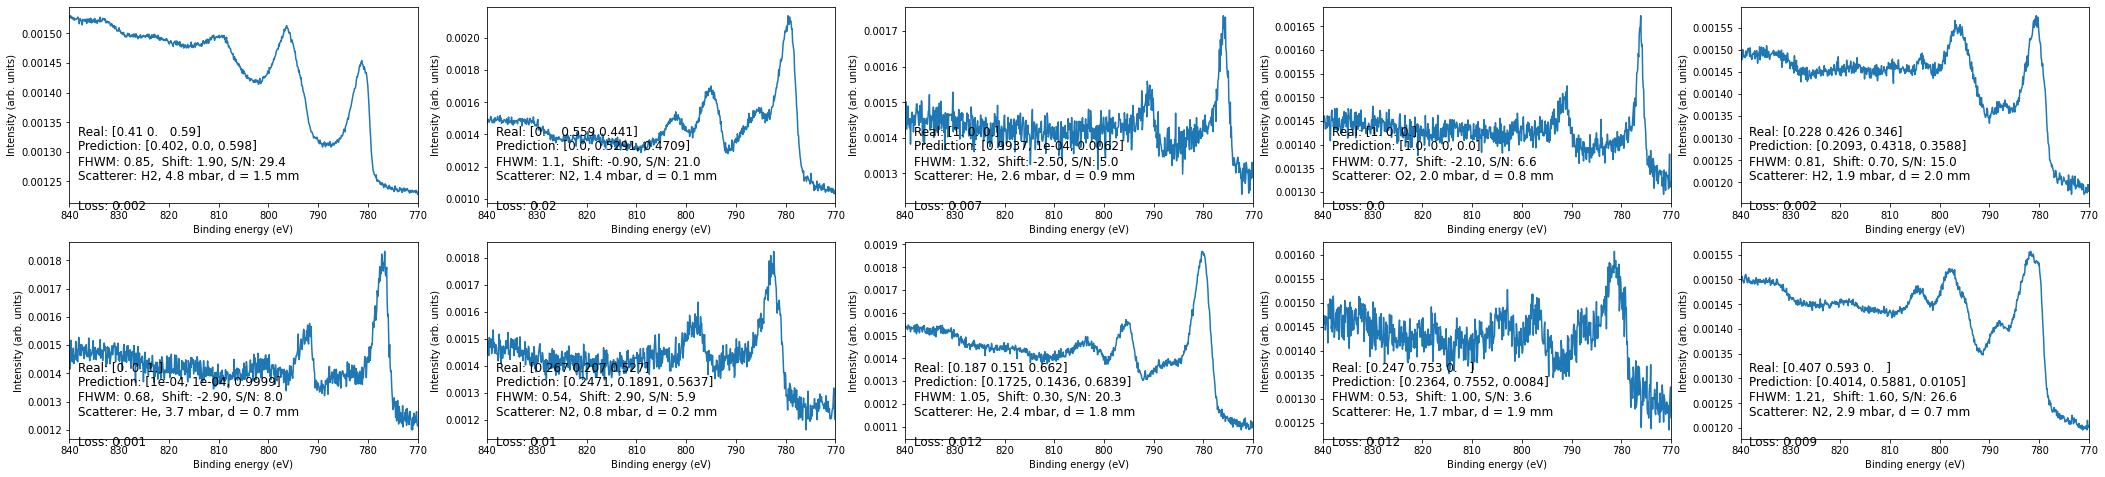

In [18]:
clf.plot_random(no_of_spectra = 10, dataset = "train", with_prediction = True)  

#### 10 random test samples

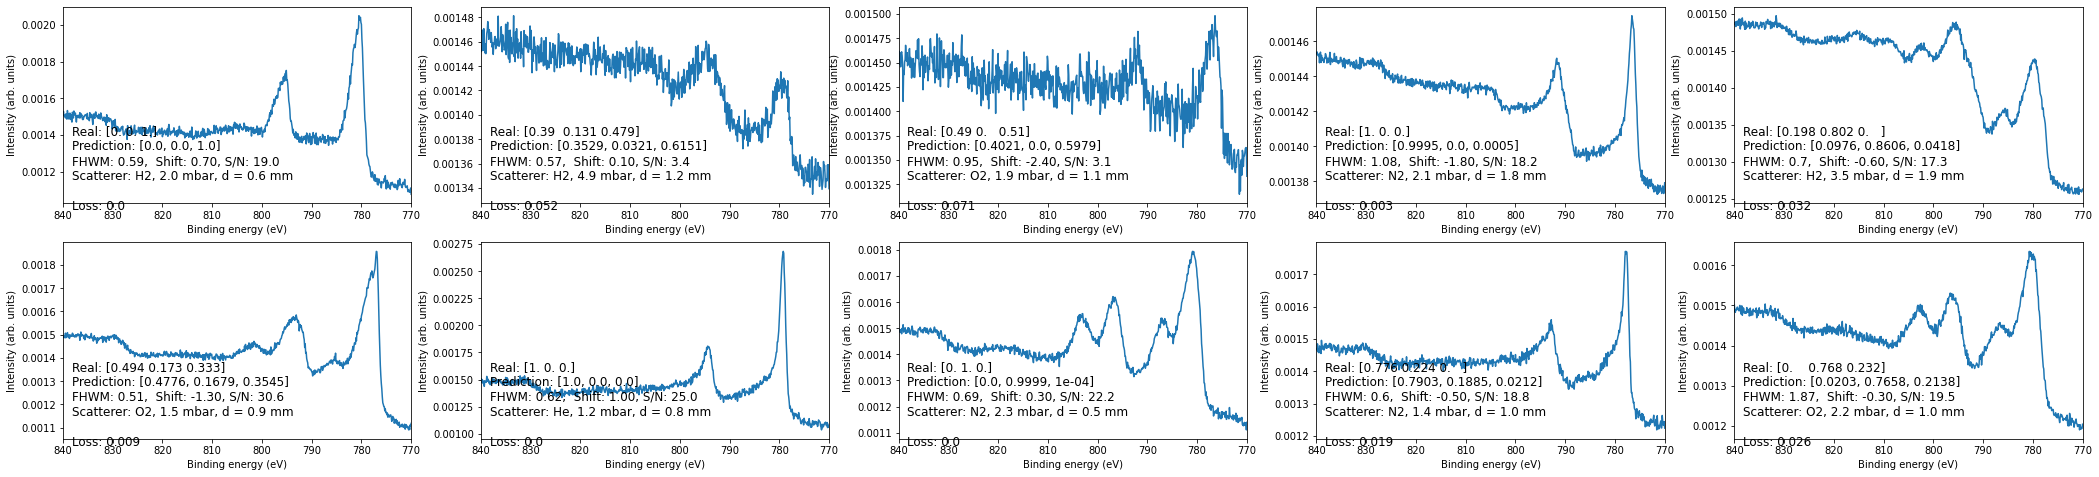

In [19]:
clf.plot_random(no_of_spectra = 10, dataset = "test", with_prediction = True)  

### Show wrong/worst predictions

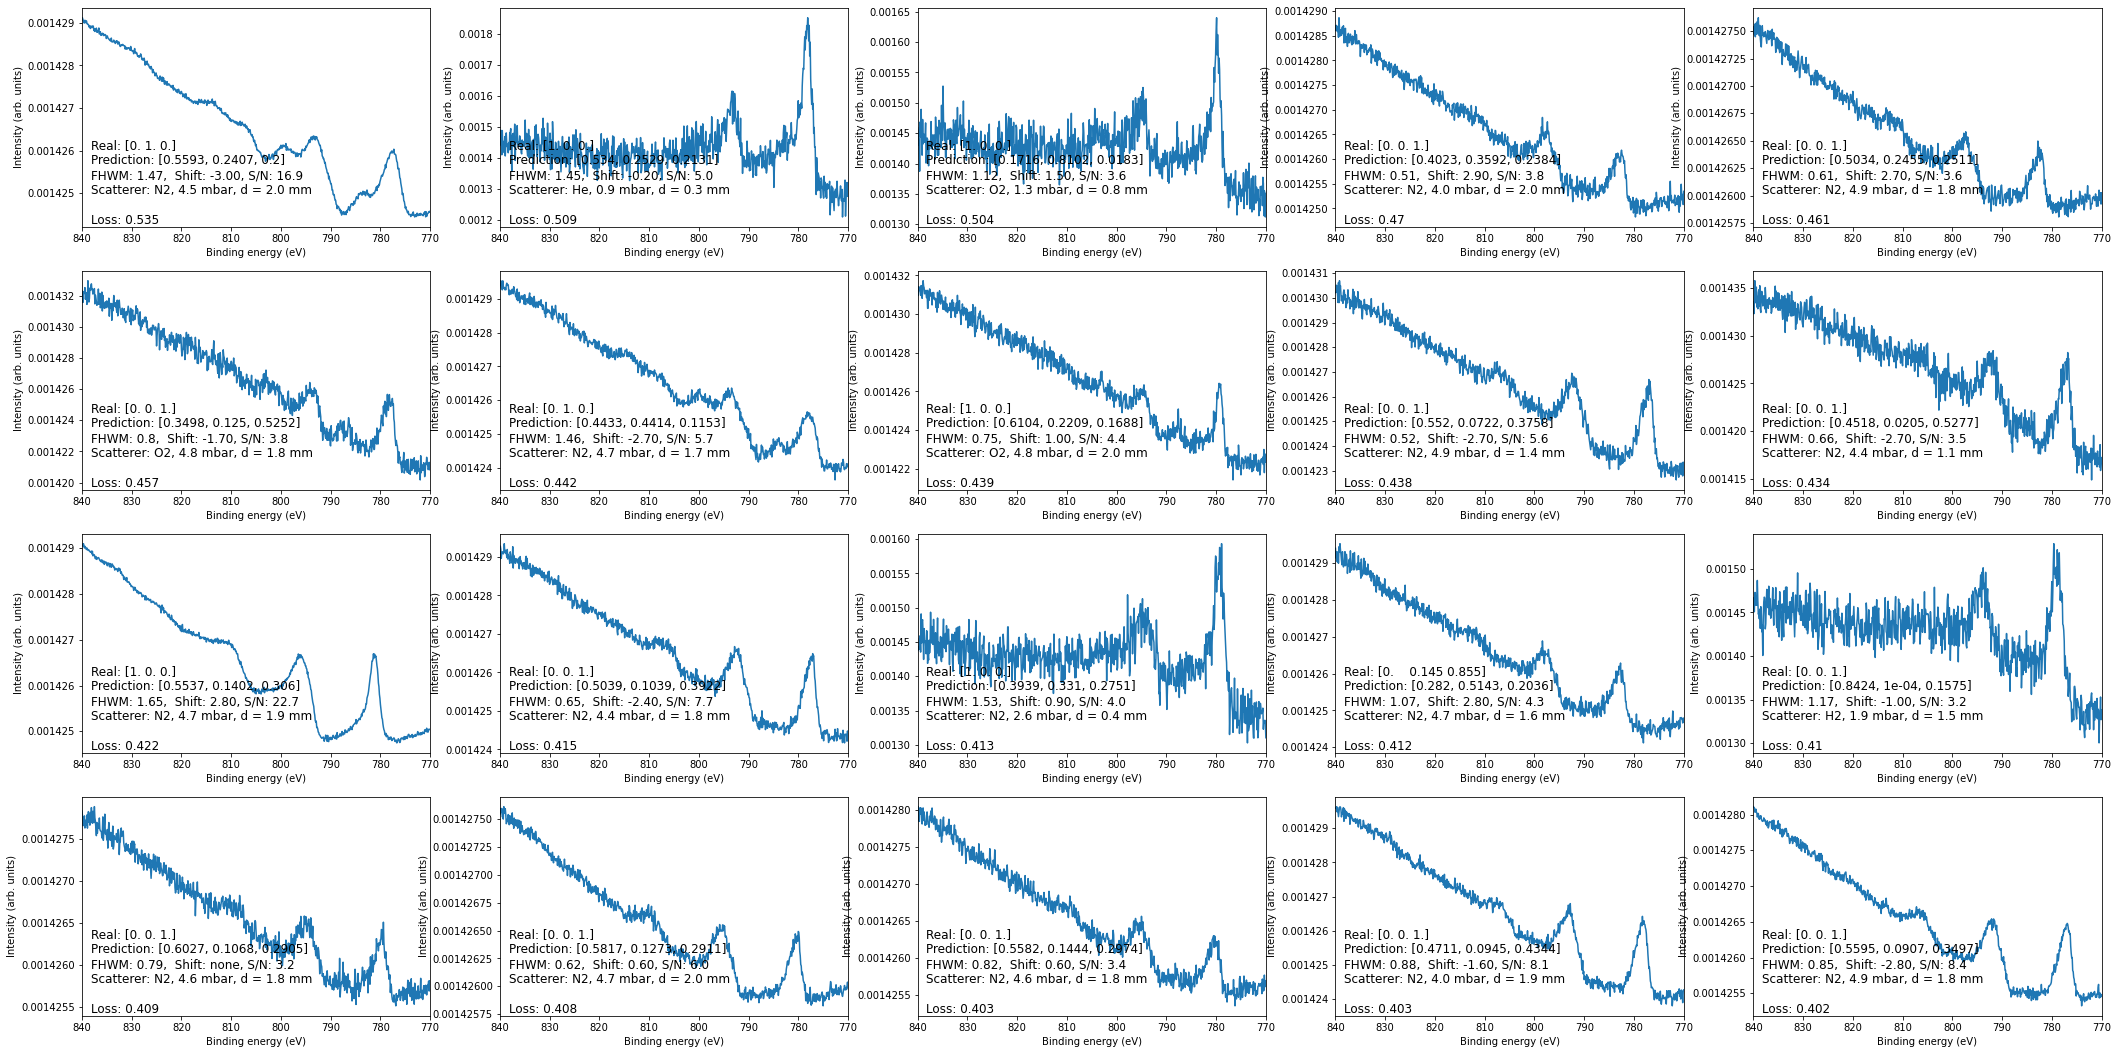

In [20]:
if clf.task == 'classification':
    clf.show_wrong_classification()
else:
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [21]:
#clf.save_model()
clf.pickle_results()

Saved results to file.


### Generate report

In [22]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

Report saved!


## Prepare website upload

In [23]:
from xpsdeeplearning.network.prepare_upload import Uploader

dataset_path = clf.logging.hyperparams["input_filepath"].rsplit(".",1)[0] + "_metadata.json"
uploader = Uploader(clf.logging.root_dir, dataset_path)
uploader.prepare_upload_params()
uploader.save_upload_params()

JSON file was prepared for upload!


## Save output of notebook

In [24]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/notebooks/train.ipynb'
output_file = os.path.join(clf.logging.log_dir,'train_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!
